In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext dotenv
%dotenv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import suggester as sg

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## 1. Preparing synthetic data

In [10]:
_config = sg.SearchConfig(api_key=os.getenv("OPENAI_API_KEY"), cache_dir="../build/cache")
_engineer = sg.SearchDataEngineer(_config)

train_context = await _engineer.generate_data(route_context="hotel agency", route_count=10, session_count=50)
test_context = await _engineer.generate_data(route_context="flight agency", route_count=10, session_count=50)

## 2. Build vectorizer 

In [11]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class RouteRecommender:
    def __init__(self, context: sg.NavigationContext):
        self.context = context
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

        self.route_data = self._prepare_route_data(context)
        self.route_documents = [data['route_document'] for data in self.route_data]
        self.route_vectors = self.vectorizer.fit_transform(self.route_documents)

    def _prepare_route_data(self, context: sg.NavigationContext):
        _routes_data = []

        _sessions = context.sessions.copy()
        _routes = context.routes.copy()

        for route in _routes:
            route_sessions = []
            for i, session in enumerate(_sessions):
                if session.route_id == route.id:
                    route_sessions.append(session)
                    _sessions.pop(i)

            tags = ' '.join(route.tags)
            route_path = route.path.translate(str.maketrans('', '', string.punctuation))
            session_context = ' '.join([session.intention.context for session in route_sessions])

            document = f"{session_context} {route_path} {tags}"

            _routes_data.append({
                'id': route.id,
                'path': route.path,
                'route_document': document
            })

        return _routes_data

    def recommend_route(self, query: str, top_n=3):
        query_vec = self.vectorizer.transform([query])

        scores = cosine_similarity(query_vec, self.route_vectors).flatten()

        sorted_indices = np.argsort(scores)[::-1][:top_n]

        return [(self.route_data[i], scores[i]) for i in sorted_indices]

### 3. Test vectorizer

In [12]:
import time

_context = train_context
recommender = RouteRecommender(_context)

def _test_query(query):
    start_time = time.time()
    results = recommender.recommend_route(query)
    latency = (time.time() - start_time)*1000

    print(f"Results ({latency:.2f}ms):")
    for route, score in results:
        print(f"- {route["id"]} | {route["path"]} (score: {score:.3f})")

for session in _context.sessions:
    route_id = session.route_id
    query = session.intention.context
    print(f"Query: '{query}'; Expected route: {route_id};")
    _test_query(query)


Query: 'Searching for hotels in New York.'; Expected route: route-1;
Results (0.42ms):
- route-1 | /hotels/search (score: 0.569)
- route-6 | /hotels/location (score: 0.217)
- route-5 | /hotels/favorites (score: 0.166)
Query: 'Looking for hotels with swimming pools.'; Expected route: route-1;
Results (0.34ms):
- route-1 | /hotels/search (score: 0.485)
- route-6 | /hotels/location (score: 0.351)
- route-5 | /hotels/favorites (score: 0.312)
Query: 'Clicked on hotel details for Hotel Sunshine.'; Expected route: route-2;
Results (0.32ms):
- route-2 | /hotels/details/:hotelId (score: 0.733)
- route-3 | /hotels/book/:hotelId (score: 0.418)
- route-4 | /hotels/reviews (score: 0.323)
Query: 'Accessing room types for Hotel Sunshine.'; Expected route: route-2;
Results (0.31ms):
- route-2 | /hotels/details/:hotelId (score: 0.524)
- route-3 | /hotels/book/:hotelId (score: 0.387)
- route-4 | /hotels/reviews (score: 0.252)
Query: 'Attempting to book a room at Hotel Sunshine.'; Expected route: route-3

### 3. Analyze model

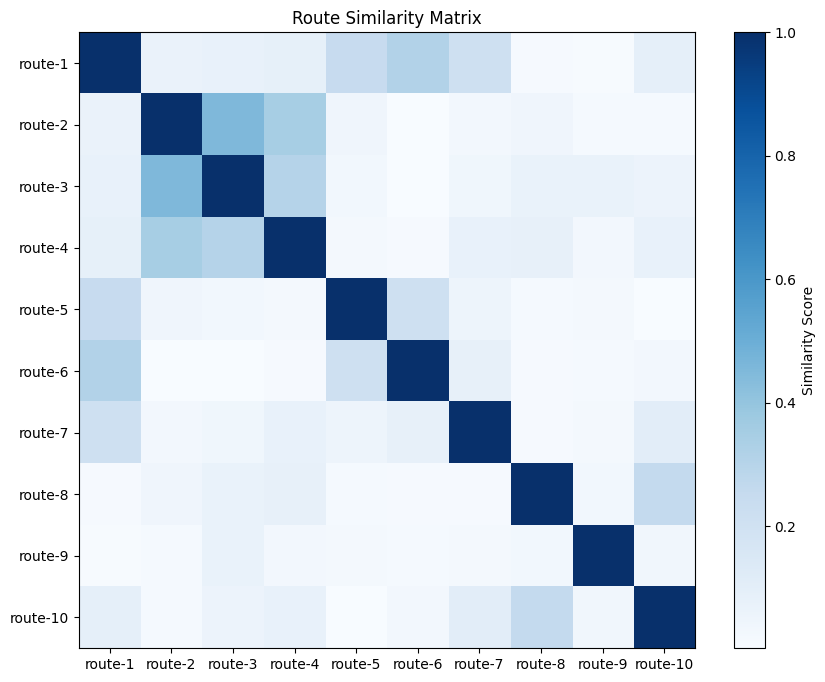

In [13]:
similarity_matrix = cosine_similarity(recommender.route_vectors)

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="Blues")

_test_routes = recommender.context.routes
plt.xticks(ticks=range(len(_test_routes)), labels=[r.id for r in _test_routes])
plt.yticks(ticks=range(len(_test_routes)), labels=[r.id for r in _test_routes])
plt.colorbar(label="Similarity Score")
plt.title("Route Similarity Matrix")
plt.show()

In [14]:
print("Vocabulary size:", len(recommender.vectorizer.vocabulary_))
print("Vector size:", sys.getsizeof(recommender.route_vectors))

Vocabulary size: 119
Vector size: 48
